In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
import anndata as ad

In [2]:
Cell_tagMulti_train = "/Users/apple/Desktop/KB/data/Cell_tag-Cell_tag_multi_integrated/Seurat_method/cell_tag_multi_train.h5ad"
Cell_tagMulti_test = "/Users/apple/Desktop/KB/data/Cell_tag-Cell_tag_multi_integrated/Seurat_method/cell_tag_multi_test.h5ad"
# load once
adata_Cell_Multi_train = ad.read_h5ad(Cell_tagMulti_train)
adata_Cell_Multi_test = ad.read_h5ad(Cell_tagMulti_test)

### load proj head embedding

In [3]:
embed_path = "/Users/apple/Desktop/KB/data/feat_LCL_2025/Cell_tag-Cell_tag_multi"

train_001_5 = np.load(embed_path + "/feat_celltagMulti_only_lambda001_unlab5_bs250_testAsPenalty/train_embed.npy")
train_001_10 = np.load(embed_path + "/feat_celltagMulti_only_lambda001_unlab10_bs250_testAsPenalty/train_embed.npy")
train_001_25 = np.load(embed_path + "/feat_celltagMulti_only_lambda001_unlab25_bs250_testAsPenalty/train_embed.npy")
train_001_50 = np.load(embed_path + "/feat_celltagMulti_only_lambda001_unlab50_bs250_testAsPenalty/train_embed.npy")


test_001_5 = np.load(embed_path + "/feat_celltagMulti_only_lambda001_unlab5_bs250_testAsPenalty/test_embed.npy")
test_001_10 = np.load(embed_path + "/feat_celltagMulti_only_lambda001_unlab10_bs250_testAsPenalty/test_embed.npy")
test_001_25 = np.load(embed_path + "/feat_celltagMulti_only_lambda001_unlab25_bs250_testAsPenalty/test_embed.npy")
test_001_50 = np.load(embed_path + "/feat_celltagMulti_only_lambda001_unlab50_bs250_testAsPenalty/test_embed.npy")

In [4]:
for i in [train_001_5, train_001_10, train_001_25, test_001_5, test_001_10, test_001_25]:
    print(i.shape)

(20251, 64)
(20251, 64)
(20251, 64)
(1987, 64)
(1987, 64)
(1987, 64)


In [5]:
adata_Cell_Multi_labels = adata_Cell_Multi_train.obs["clone_id"].to_numpy()  # keep user’s dtype; NaN ok
adata_Cell_tag_labels  = adata_Cell_Multi_test.obs["clone_id"].to_numpy()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import umap

def umap_embed_train_test(train_emb, test_emb, n_neighbors=15, min_dist=0.3, random_state=42):
    """
    Concatenate train & test embeddings, run UMAP, and color by 'train'/'test'.
    Ensures train points are plotted on top of test points.
    
    Returns:
        emb2d_train: UMAP coords for train samples
        emb2d_test:  UMAP coords for test samples
    """
    # 1) Combine embeddings
    emb_combined = np.vstack([train_emb, test_emb])

    # 2) Create labels
    split_labels = np.array(
        ["train"] * train_emb.shape[0] + ["test"] * test_emb.shape[0]
    )

    # 3) Run UMAP
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric='euclidean',
        random_state=random_state
    )
    emb2d = reducer.fit_transform(emb_combined)

    # 4) Split back into train/test coords
    n_train = train_emb.shape[0]
    emb2d_train = emb2d[:n_train]
    emb2d_test  = emb2d[n_train:]

    return emb2d_train, emb2d_test
def plot_train_test_umap(emb2d_train, emb2d_test):
    """
    Concatenate train & test embeddings, run UMAP, and color by 'train'/'test'.
    Ensures train points are plotted on top of test points.
    """
    
    # 4) Plot — plot 'test' first, then 'train'
    plt.figure(figsize=(7, 6))

    plt.scatter(
        emb2d_train[:, 0], emb2d_train[:, 1],
        c="tab:blue", label="train", s=8, alpha=0.3
    )
    plt.scatter(
        emb2d_test[:, 0], emb2d_test[:, 1],
        c="tab:orange", label="test", s=8, alpha=0.8
    )

    plt.title("UMAP — Train on Top of Test")
    plt.xticks([]); plt.yticks([])
    plt.legend(markerscale=1.5, frameon=True)
    plt.tight_layout()
    plt.show()
def plot_top5_umap(emb2d, labels, title):
    """
    emb: np.ndarray (n_cells, n_features) – your high-dim embeddings
    labels: 1D array-like of clone_id (ints or floats; NaN/-1 treated as 'other')
    """
    labels = pd.Series(labels).copy()

    # Treat missing as 'other'
    # If you already use -1 for unlabeled, this preserves it.
    labels_clean = labels.copy()
    labels_clean = labels_clean.where(~labels_clean.isna(), -1)

    # Top-5 clone_ids by count, excluding unlabeled (-1)
    top_ids = (
        labels_clean[labels_clean != -1]
        .value_counts()
        .head(5)
        .index.tolist()
    )
    
    # Masks
    is_top = labels_clean.isin(top_ids)
    is_other = ~is_top

    # Plot
    plt.figure(figsize=(7, 6))
    # Background first: gray
    plt.scatter(
        emb2d[is_other, 0], emb2d[is_other, 1],
        c="lightgray", s=6, alpha=0.5, linewidths=0, label="other"
    )

    # Use default matplotlib color cycle for the 5 groups
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

    for i, cid in enumerate(top_ids):
        mask = labels_clean == cid
        plt.scatter(
            emb2d[mask, 0], emb2d[mask, 1],
            s=10, alpha=0.9, linewidths=0,
            label=f"clone_id {cid}",
            c=color_cycle[i % len(color_cycle)]
        )

    plt.title(title)
    plt.xticks([]); plt.yticks([])
    plt.legend(markerscale=1.2, frameon=True, fontsize=9)
    plt.tight_layout()
    plt.show()

In [7]:
emb2d_train_001_5, emb2d_test_001_5 = umap_embed_train_test(train_001_5, test_001_5)
emb2d_train_001_10, emb2d_test_001_10 = umap_embed_train_test(train_001_10, test_001_10)
emb2d_train_001_25, emb2d_test_001_25 = umap_embed_train_test(train_001_25, test_001_25)
emb2d_train_001_50, emb2d_test_001_50 = umap_embed_train_test(train_001_50, test_001_50)


/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


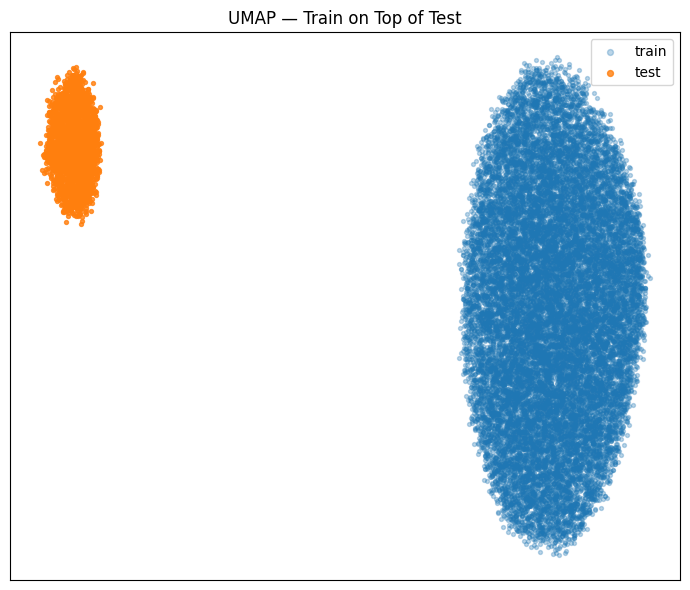

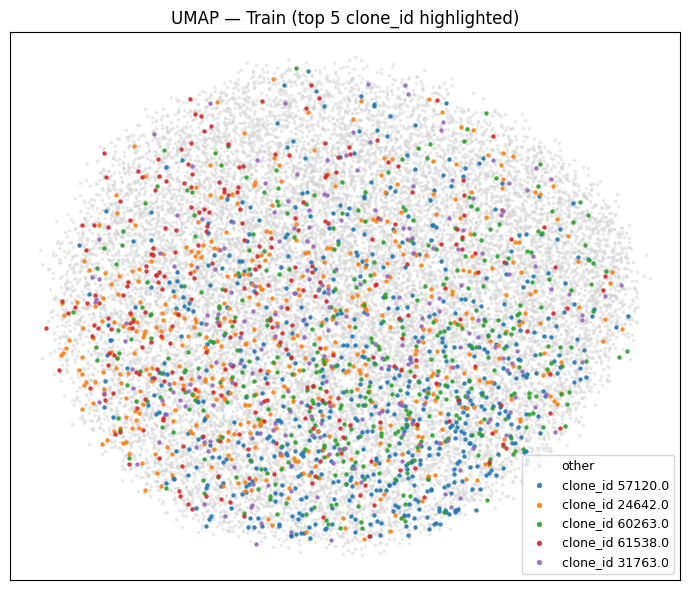

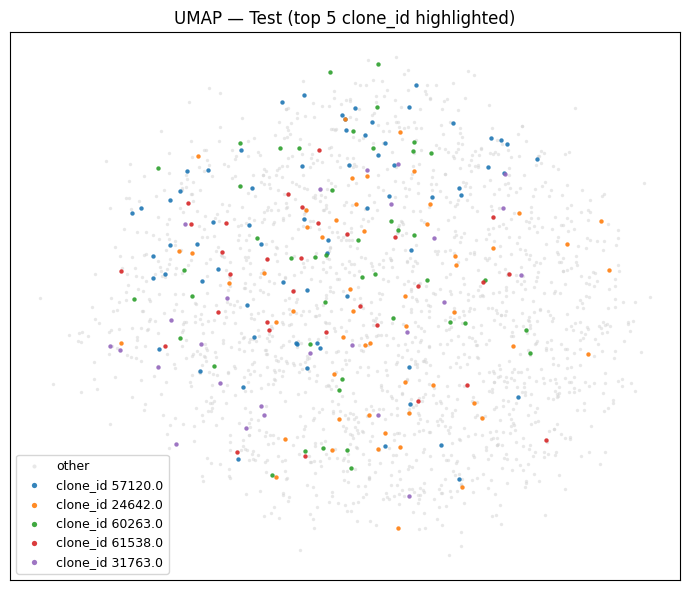

In [8]:
plot_train_test_umap(emb2d_train_001_5, emb2d_test_001_5)
plot_top5_umap(emb2d_train_001_5, adata_Cell_Multi_labels, title="UMAP — Train (top 5 clone_id highlighted)")
plot_top5_umap(emb2d_test_001_5,  adata_Cell_tag_labels,  title="UMAP — Test (top 5 clone_id highlighted)")

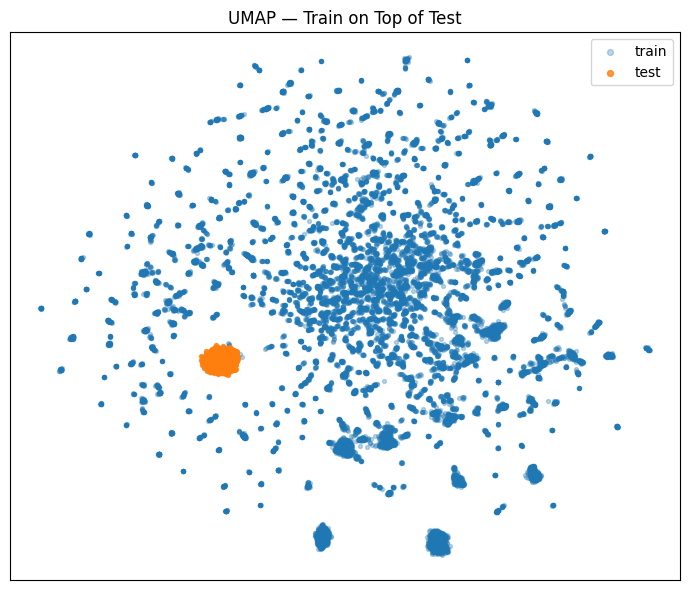

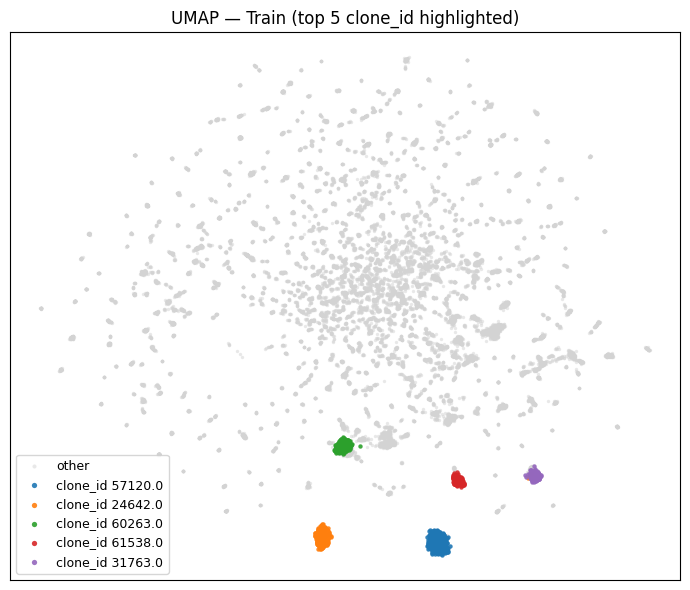

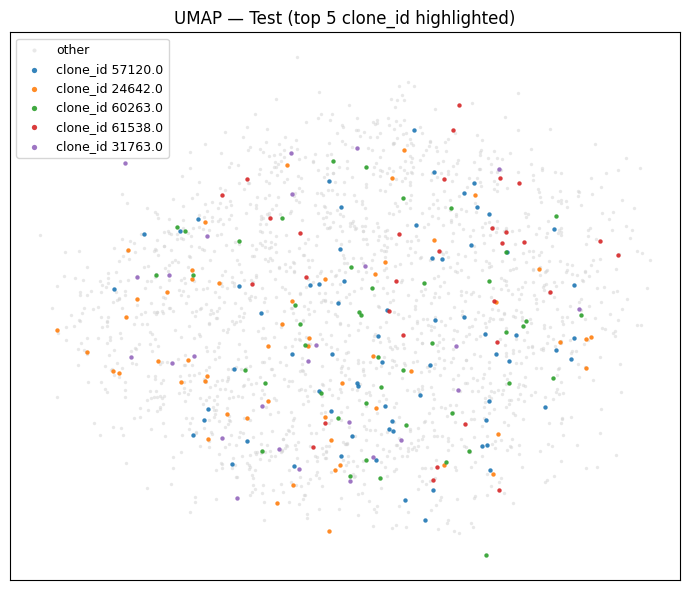

In [10]:
plot_train_test_umap(emb2d_train_001_10, emb2d_test_001_10)
plot_top5_umap(emb2d_train_001_10, adata_Cell_Multi_labels, title="UMAP — Train (top 5 clone_id highlighted)")
plot_top5_umap(emb2d_test_001_10,  adata_Cell_tag_labels,  title="UMAP — Test (top 5 clone_id highlighted)")

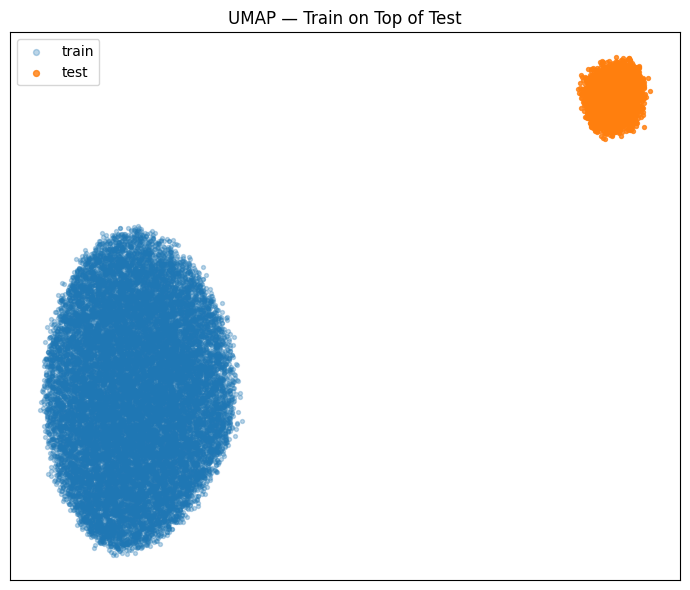

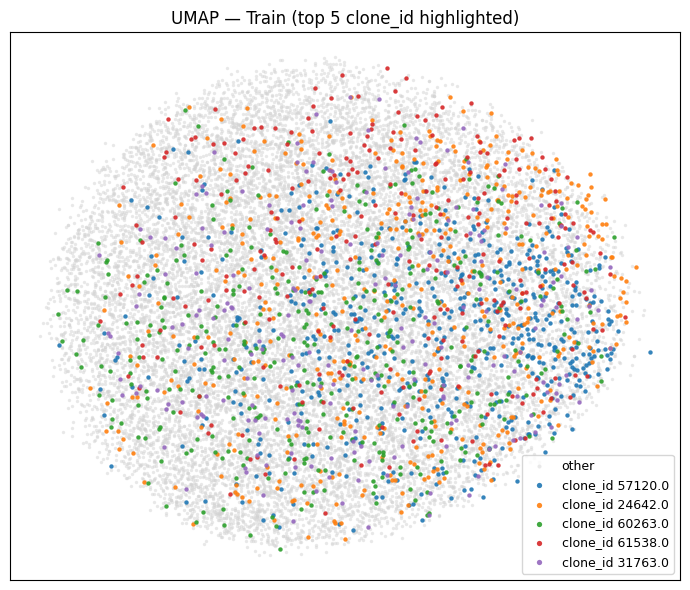

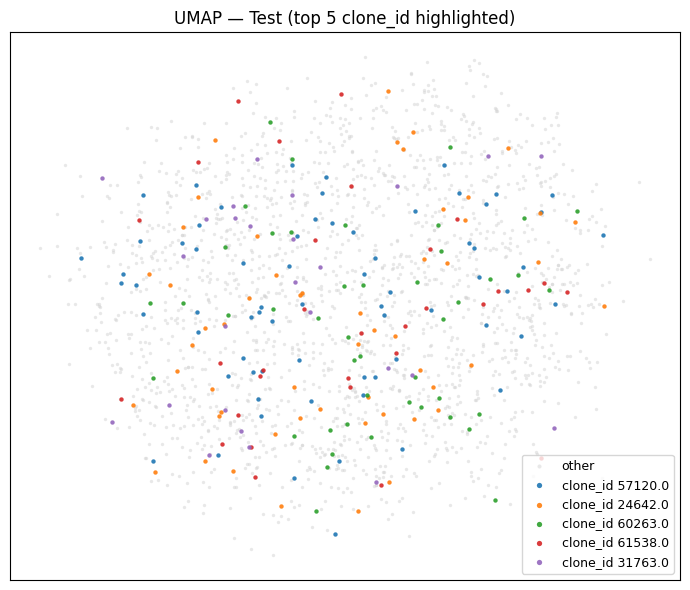

In [13]:
plot_train_test_umap(emb2d_train_001_25, emb2d_test_001_25)
plot_top5_umap(emb2d_train_001_25, adata_Cell_Multi_labels, title="UMAP — Train (top 5 clone_id highlighted)")
plot_top5_umap(emb2d_test_001_25,  adata_Cell_tag_labels,  title="UMAP — Test (top 5 clone_id highlighted)")

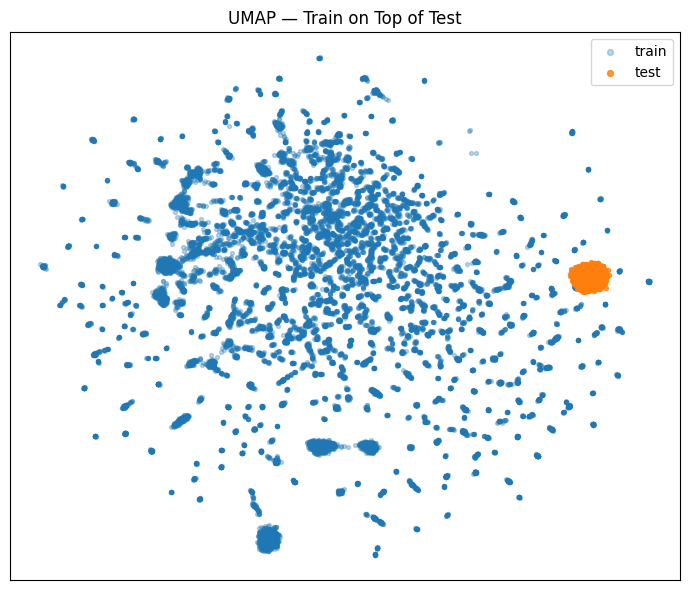

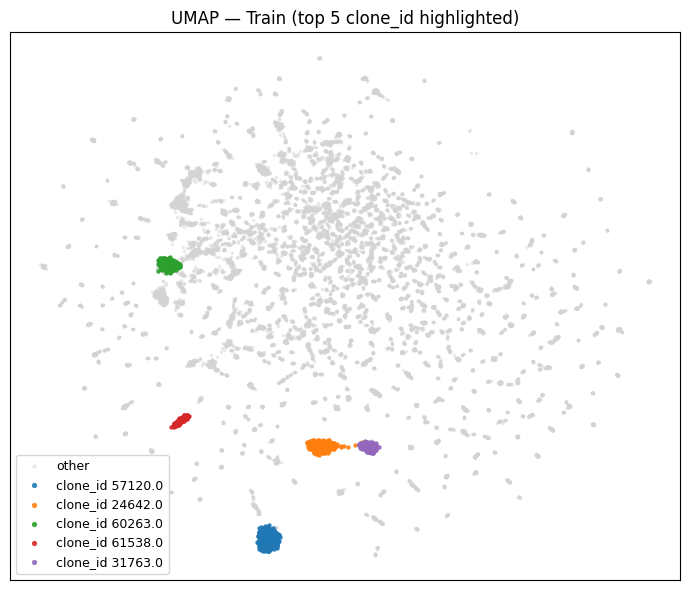

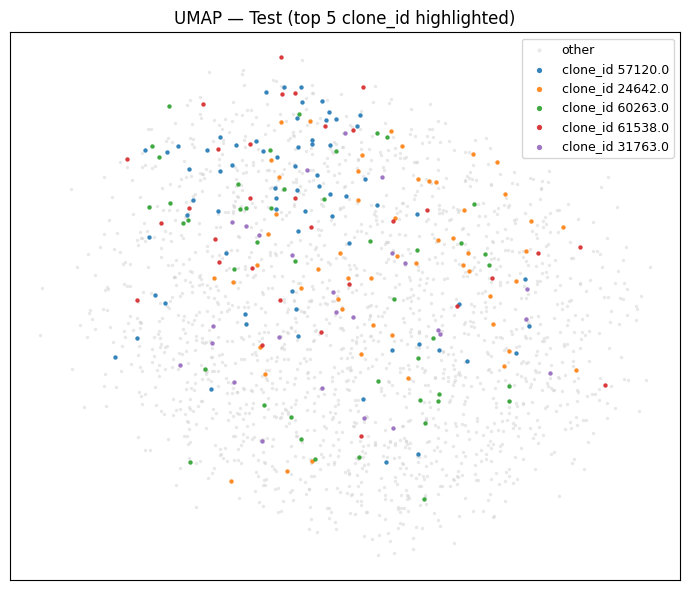

In [14]:
plot_train_test_umap(emb2d_train_001_50, emb2d_test_001_25)
plot_top5_umap(emb2d_train_001_50, adata_Cell_Multi_labels, title="UMAP — Train (top 5 clone_id highlighted)")
plot_top5_umap(emb2d_test_001_50,  adata_Cell_tag_labels,  title="UMAP — Test (top 5 clone_id highlighted)")

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

def KNN_test_topN(train_embedding, test_embedding, train_labels, test_labels, n_neighbors=10, top_n=3):
    # Convert labels to pandas Series for convenience
    test_labels_series = pd.Series(test_labels)
    
    # Find top-N clones in test set
    top_clones = test_labels_series.value_counts().head(top_n).index.tolist()
    
    # Filter test set for these clones
    mask = test_labels_series.isin(top_clones)
    test_emb_top = test_embedding[mask.values]
    test_labels_top = test_labels_series[mask].values
    
    if len(test_labels_top) == 0:
        raise ValueError(f"No test samples found for top-{top_n} clones.")
    
    # Train KNN on full training set
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_model.fit(train_embedding, train_labels)
    
    # Predict on restricted test set
    y_pred = knn_model.predict(test_emb_top)
    accuracy = accuracy_score(test_labels_top, y_pred)
    
    print(f"KNN classifier accuracy on top-{top_n} test clones: {accuracy * 100:.2f}%")
    
    return accuracy

In [16]:
top_n_ls = [563, 500, 400, 200, 100, 50, 25, 10, 5]

acc_df = pd.DataFrame(
    np.zeros((len(top_n_ls), 4)),
    index=top_n_ls,
    columns=["001_5", "001_10", "001_25", "001_50"]
)

for i, topn in enumerate(top_n_ls):
    acc__001_5  = KNN_test_topN(train_001_5,  test_001_5,  adata_Cell_Multi_labels, adata_Cell_tag_labels, top_n=topn)
    acc__001_10 = KNN_test_topN(train_001_10, test_001_10, adata_Cell_Multi_labels, adata_Cell_tag_labels, top_n=topn)
    acc__001_25 = KNN_test_topN(train_001_25, test_001_25, adata_Cell_Multi_labels, adata_Cell_tag_labels, top_n=topn)
    acc__001_50 = KNN_test_topN(train_001_50, test_001_50, adata_Cell_Multi_labels, adata_Cell_tag_labels, top_n=topn)


    acc_df.iloc[i, 0] = round(float(acc__001_5), 4)
    acc_df.iloc[i, 1] = round(float(acc__001_10), 4)
    acc_df.iloc[i, 2] = round(float(acc__001_25), 4)
    acc_df.iloc[i, 3] = round(float(acc__001_50), 4)

print(acc_df)


/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


KNN classifier accuracy on top-563 test clones: 0.40%
KNN classifier accuracy on top-563 test clones: 0.00%
KNN classifier accuracy on top-563 test clones: 0.96%
KNN classifier accuracy on top-563 test clones: 0.20%
KNN classifier accuracy on top-500 test clones: 0.42%
KNN classifier accuracy on top-500 test clones: 0.00%
KNN classifier accuracy on top-500 test clones: 0.94%
KNN classifier accuracy on top-500 test clones: 0.21%
KNN classifier accuracy on top-400 test clones: 0.47%
KNN classifier accuracy on top-400 test clones: 0.00%
KNN classifier accuracy on top-400 test clones: 1.05%
KNN classifier accuracy on top-400 test clones: 0.23%
KNN classifier accuracy on top-200 test clones: 0.63%
KNN classifier accuracy on top-200 test clones: 0.00%
KNN classifier accuracy on top-200 test clones: 1.41%
KNN classifier accuracy on top-200 test clones: 0.31%
KNN classifier accuracy on top-100 test clones: 0.75%
KNN classifier accuracy on top-100 test clones: 0.00%
KNN classifier accuracy on t

In [17]:
acc_df

,001_5,001_10,001_25,001_50
563,0.0040,0.0,0.0096,0.0020
500,0.0042,0.0,0.0094,0.0021
400,0.0047,0.0,0.0105,0.0023
200,0.0063,0.0,0.0141,0.0031
100,0.0075,0.0,0.0182,0.0000
50,0.0102,0.0,0.0233,0.0000
25,0.0136,0.0,0.0312,0.0000
10,0.0179,0.0,0.0418,0.0000
5,0.0267,0.0,0.0578,0.0000
